$\newcommand{\mb}[1]{\mathbf{ #1 }}$
$\newcommand{\bb}[1]{\mathbb{ #1 }}$
$\newcommand{\bs}[1]{\boldsymbol{ #1 }}$

$\newcommand{\norm}[1]{\left\Vert #1 \right\Vert}$
$\newcommand{\der}[2]{\frac{ \mathrm{d} #1 }{ \mathrm{d} #2 }}$
$\newcommand{\derp}[2]{\frac{ \partial #1 }{ \partial #2 }}$

$\newcommand{\R}{\bb{R}}$

# Learning Dynamics

## Robotic Systems

Let $\mathcal{Q} \subseteq \R^n$ be a configuration space. Consider a robotic system governed by:

\begin{equation}
    \mb{D}(\mb{q})\ddot{\mb{q}} + \mb{C}(\mb{q}, \dot{\mb{q}})\dot{\mb{q}} + \mb{G}(\mb{q}) = \mb{B}\mb{u},
\end{equation}

for generalized coordinates $\mb{q} \in \mathcal{Q}$, coordinate rates $\dot{\mb{q}} \in \R^n$, actions $\mb{u} \in \R^m$, inertia matrix function $\mb{D}: \mathcal{Q} \to \bb{S}^n_{++}$ (the space of $n \times n$ positive definite matrices), Coriolis terms $\mb{C}: \mathcal{Q} \times \R^n \to \R^{n \times n}$, potential terms $\mb{G}: \mathcal{Q} \to \R^n$, and static actuation matrix $\mb{B} \in \R^{n \times m}$. Assume $m \leq n$ and $\mb{B}$ is full rank.

In [1]:
from matplotlib.pyplot import show, subplots
from numpy import array, identity, linspace

from core.controllers import FBLinController, LQRController

# Simulation times
ts = linspace(0, 10, 1000 + 1)

# Plotting parameters
width = 6
height = 4

### Inverted Pendulum

In [2]:
from core.systems import InvertedPendulum

ip = InvertedPendulum(m=0.25, l=0.5)

In [3]:
Q_ip = 10 * identity(2)
R_ip = identity(1)
lqr_ip = LQRController.build(ip, Q_ip, R_ip)
fb_lin_ip = FBLinController(ip, lqr_ip)

In [4]:
x_0_ip = array([1, 0])
data_ip_oracle = ip.simulate(x_0_ip, fb_lin_ip, ts)

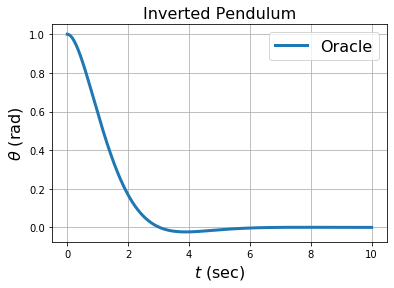

In [5]:
xs, _ = data_ip_oracle
qs = xs[:, :1]

fig_ip, ax_ip = subplots(figsize=(width, height))

ax_ip.plot(ts, (qs.T)[0], linewidth=3, label='Oracle')
ax_ip.grid()
ax_ip.legend(fontsize=16)
ax_ip.set_title('Inverted Pendulum', fontsize=16)
ax_ip.set_xlabel('$t$ (sec)', fontsize=16)
ax_ip.set_ylabel('$\\theta$ (rad)', fontsize=16)

show()

### Double Inverted Pendulum

In [6]:
from core.systems import DoubleInvertedPendulum

dip = DoubleInvertedPendulum(m_1=0.25, m_2=0.25, l_1=0.5, l_2=0.5)

In [7]:
Q_dip = 10 * identity(4)
R_dip = identity(2)
lqr_dip = LQRController.build(dip, Q_dip, R_dip)
fb_lin_dip = FBLinController(dip, lqr_dip)

In [8]:
x_0_dip = array([1, 0, 0, 0])
data_dip_oracle = dip.simulate(x_0_dip, fb_lin_dip, ts)

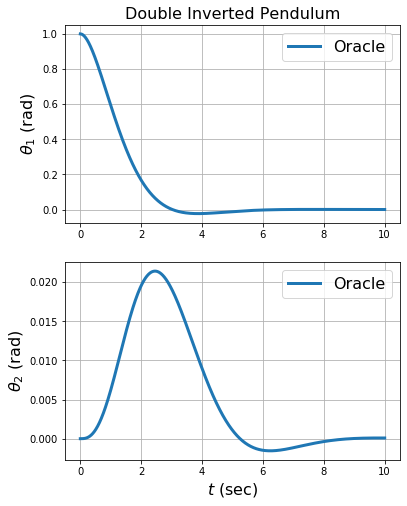

In [9]:
xs, _ = data_dip_oracle
qs = xs[:, :2]

fig_dip, axs_dip = subplots(2, figsize=(width, 2 * height))
axs_dip[0].set_title('Double Inverted Pendulum', fontsize=16)
axs_dip[-1].set_xlabel('$t$ (sec)', fontsize=16)
ylabels = ['$\\theta_1$ (rad)', '$\\theta_2$ (rad)']

for ax, data, ylabel in zip(axs_dip, qs.T, ylabels):
    ax.plot(ts, data, linewidth=3, label='Oracle')
    ax.grid()
    ax.legend(fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)

show()

### Satellite

In [10]:
from numpy import diag, ones

from core.systems import Satellite

J = diag([10, 10, 40]) + 2 * ones((3, 3))
rot_order = [1, 2, 3]
sat = Satellite(J, rot_order)

In [11]:
Q_sat = 10 * identity(6)
R_sat = identity(3)
lqr_sat = LQRController.build(sat, Q_sat, R_sat)
fb_lin_sat = FBLinController(sat, lqr_sat)

In [12]:
x_0_sat = array([0, 0, 0, 1, 1, 1])
data_sat_oracle = sat.simulate(x_0_sat, fb_lin_sat, ts)

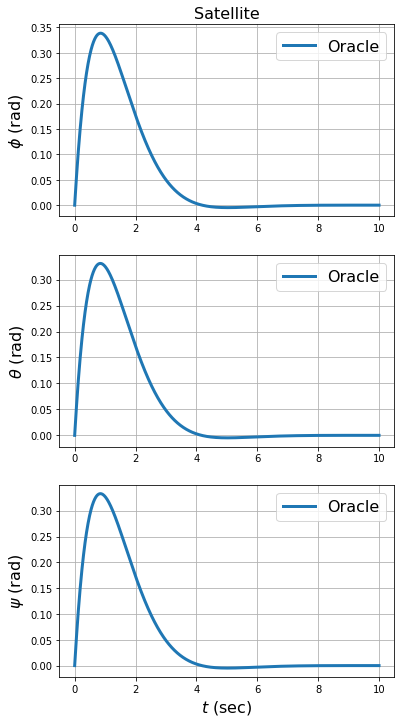

In [13]:
xs, _ = data_sat_oracle
qs = xs[:, :3]

fig_sat, axs_sat = subplots(3, figsize=(width, 3 * height))
axs_sat[0].set_title('Satellite', fontsize=16)
axs_sat[-1].set_xlabel('$t$ (sec)', fontsize=16)
ylabels = ['$\\phi$ (rad)', '$\\theta$ (rad)', '$\\psi$ (rad)']

for ax, data, ylabel in zip(axs_sat, qs.T, ylabels):
    ax.plot(ts, data, linewidth=3, label='Oracle')
    ax.grid()
    ax.legend(fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    
show()

## Uncertain Robotic Systems

Suppose $\mb{D}$, $\mb{C}$, $\mb{G}$, and $\mb{B}$ are unknown, and instead we have access to corresponding estimates $\hat{\mb{D}}$, $\hat{\mb{C}}$, $\hat{\mb{G}}$, and $\hat{\mb{B}}$ satisfying:

\begin{equation}
    \hat{\mb{D}}(\mb{q})\ddot{\mb{q}} + \hat{\mb{C}}(\mb{q}, \dot{\mb{q}})\dot{\mb{q}} + \hat{\mb{G}}(\mb{q}) = \hat{\mb{B}}\mb{u}.
\end{equation}

Assume that $\hat{\mb{B}}$ is also full rank.

The system dynamics can be in terms of the estimated terms as:

\begin{equation}
    \der{}{t} \begin{bmatrix} \mb{q} \\ \dot{\mb{q}} \end{bmatrix} = \begin{bmatrix} \dot{\mb{q}} \\ -\hat{\mb{D}}(\mb{q})^{-1}(\hat{\mb{C}}(\mb{q}, \dot{\mb{q}})\dot{\mb{q}} + \hat{\mb{G}}(\mb{q})) \end{bmatrix} + \begin{bmatrix} \mb{0}_{n \times m} \\ \hat{\mb{D}}(\mb{q})^{-1}\hat{\mb{B}} \end{bmatrix} \mb{u} + \begin{bmatrix} \mb{0}_n \\ \hat{\mb{D}}(\mb{q})^{-1}(\hat{\mb{C}}(\mb{q}, \dot{\mb{q}})\dot{\mb{q}} + \hat{\mb{G}}(\mb{q}))-\mb{D}(\mb{q})^{-1}(\mb{C}(\mb{q}, \dot{\mb{q}})\dot{\mb{q}} + \mb{G}(\mb{q})) \end{bmatrix} + \begin{bmatrix} \mb{0}_{n \times m} \\ \mb{D}(\mb{q})^{-1}\mb{B} - \hat{\mb{D}}(\mb{q})^{-1}\hat{\mb{B}} \end{bmatrix} \mb{u}
\end{equation}

### Inverted Pendulum

In [14]:
ip_est = InvertedPendulum(m=0.24, l=0.48)

In [15]:
lqr_ip_est = LQRController.build(ip_est, Q_ip, R_ip)
fb_lin_ip_est = FBLinController(ip_est, lqr_ip_est)

In [16]:
data_ip = ip.simulate(x_0_ip, fb_lin_ip_est, ts)

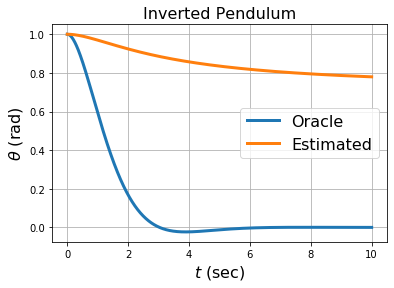

In [17]:
xs, _ = data_ip
qs = xs[:, :1]

ax_ip.plot(ts, (qs.T)[0], linewidth=3, label='Estimated')
ax_ip.legend(fontsize=16)
fig_ip

### Double Inverted Pendulum

In [18]:
dip_est = DoubleInvertedPendulum(m_1=0.24, m_2=0.24, l_1=0.48, l_2=0.48)

In [19]:
lqr_dip_est = LQRController.build(dip_est, Q_dip, R_dip)
fb_lin_dip_est = FBLinController(dip_est, lqr_dip_est)

In [20]:
data_dip = dip.simulate(x_0_dip, fb_lin_dip_est, ts)

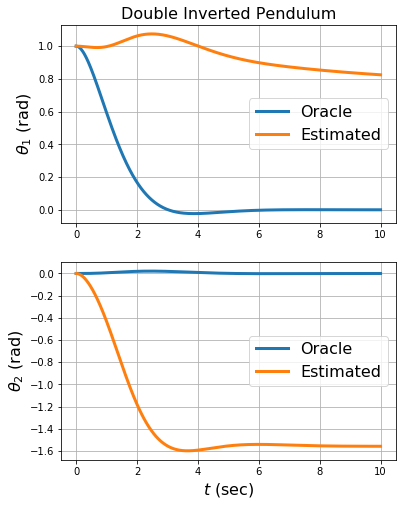

In [21]:
xs, _ = data_dip
qs = xs[:, :2]

for ax, data in zip(axs_dip, qs.T):
    ax.plot(ts, data, linewidth=3, label='Estimated')
    ax.legend(fontsize=16)

fig_dip

### Satellite

In [22]:
J_est = diag([10, 10, 40])
sat_est = Satellite(J_est, rot_order)

In [23]:
lqr_sat_est = LQRController.build(sat_est, Q_sat, R_sat)
fb_lin_sat_est = FBLinController(sat_est, lqr_sat_est)

In [24]:
data_sat = sat.simulate(x_0_sat, fb_lin_sat_est, ts)

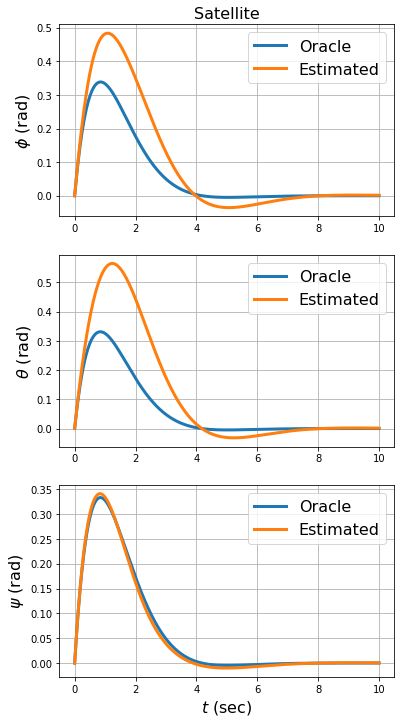

In [25]:
xs, _ = data_sat
qs = xs[:, :3]

for ax, data in zip(axs_sat, qs.T):
    ax.plot(ts, data, linewidth=3, label='Estimated')
    ax.legend(fontsize=16)
    
fig_sat

## Learning Dynamics

In [26]:
from tensorflow.logging import ERROR, set_verbosity
set_verbosity(ERROR)

In [27]:
from core.dynamics import LearnedFBLinDynamics

class LearnedRoboticDynamics(LearnedFBLinDynamics):
    def __init__(self, robotic_dynamics, res_aff_model, trust=1):
        LearnedFBLinDynamics.__init__(self, robotic_dynamics, res_aff_model, trust)
        
    def process_drift(self, x, t):
        return x
    
    def process_act(self, x, t):
        return x[:self.dynamics.k]

In [28]:
from core.learning.keras import KerasResidualAffineModel

Using TensorFlow backend.


### Inverted Pendulum

In [29]:
d_drift_in_ip = 2
d_act_in_ip = 1
d_hidden_ip = 20
d_out_ip = 1

res_model_ip = KerasResidualAffineModel.build(d_drift_in_ip, d_act_in_ip, d_hidden_ip, 1, d_out_ip, 'adam')

In [30]:
ip_learned = LearnedRoboticDynamics(ip_est, res_model_ip)
xs, us = data_ip
data = ip_learned.process_episode(xs, us, ts)
ip_learned.fit(data, num_epochs=10)

Epoch 1/10
998/998 [==============================] - 2s 2ms/step - loss: 0.1106
Epoch 2/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0027
Epoch 3/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0024
Epoch 4/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0025
Epoch 5/10
998/998 [==============================] - 3s 3ms/step - loss: 0.0024
Epoch 6/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0022
Epoch 7/10
998/998 [==============================] - 3s 3ms/step - loss: 0.0024
Epoch 8/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0019
Epoch 9/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0020
Epoch 10/10
998/998 [==============================] - 3s 3ms/step - loss: 0.0022


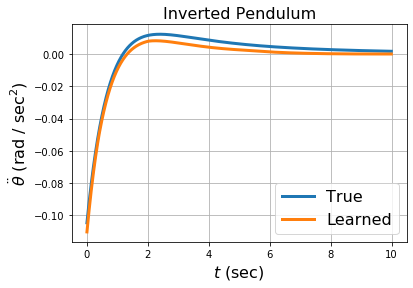

In [31]:
x_dots = array([ip.eval_dot(x, u, t) for x, u, t in zip(xs, us, ts)])
q_ddots = x_dots[:, -1:]

_, ax = subplots(figsize=(width, height))

ax.plot(ts[:-1], (q_ddots.T)[0], linewidth=3, label='True')
ax.grid()
ax.set_title('Inverted Pendulum', fontsize=16)
ax.set_xlabel('$t$ (sec)', fontsize=16)
ax.set_ylabel('$\\ddot{\\theta}$ (rad / sec$^2$)', fontsize=16)

x_dots = array([ip_learned.eval_dot(x, u, t) for x, u, t in zip(xs, us, ts)])
q_ddots = x_dots[:, -1:]

ax.plot(ts[:-1], x_dots[:, 1], linewidth=3, label='Learned')
ax.legend(fontsize=16)

show()

### Double Inverted Pendulum

In [32]:
d_drift_in_dip = 4
d_act_in_dip = 2
d_hidden_dip = 40
d_out_dip = 2

res_model_dip = KerasResidualAffineModel.build(d_drift_in_dip, d_act_in_dip, d_hidden_dip, 2, d_out_dip, 'adam')

In [33]:
dip_learned = LearnedRoboticDynamics(dip_est, res_model_dip)
xs, us = data_dip
data = dip_learned.process_episode(xs, us, ts)
dip_learned.fit(data, num_epochs=10)

Epoch 1/10
998/998 [==============================] - 4s 4ms/step - loss: 0.1191
Epoch 2/10
998/998 [==============================] - 3s 3ms/step - loss: 0.0382
Epoch 3/10
998/998 [==============================] - 3s 3ms/step - loss: 0.0262
Epoch 4/10
998/998 [==============================] - 3s 3ms/step - loss: 0.0255
Epoch 5/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0230
Epoch 6/10
998/998 [==============================] - 3s 3ms/step - loss: 0.0226
Epoch 7/10
998/998 [==============================] - 3s 3ms/step - loss: 0.0219
Epoch 8/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0214
Epoch 9/10
998/998 [==============================] - 3s 3ms/step - loss: 0.0221
Epoch 10/10
998/998 [==============================] - 3s 3ms/step - loss: 0.0203


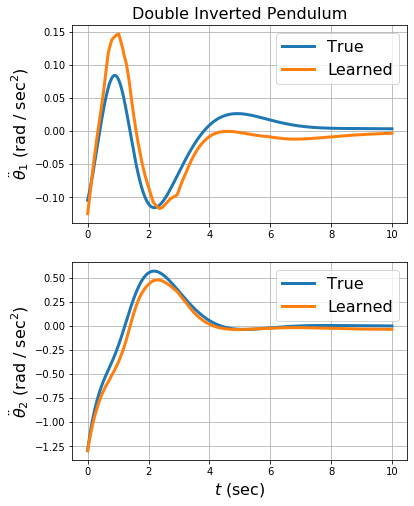

In [34]:
x_dots = array([dip.eval_dot(x, u, t) for x, u, t in zip(xs, us, ts)])
q_ddots = x_dots[:, -2:]

_, axs = subplots(2, figsize=(width, 2 * height))
axs[0].set_title('Double Inverted Pendulum', fontsize=16)
axs[-1].set_xlabel('$t$ (sec)', fontsize=16)
ylabels = ['$\\ddot{\\theta}_1$ (rad / sec$^2$)', '$\\ddot{\\theta}_2$ (rad / sec$^2$)']

for ax, data, ylabel in zip(axs, q_ddots.T, ylabels):
    ax.plot(ts[:-1], data, linewidth=3, label='True')
    ax.grid()
    ax.set_ylabel(ylabel, fontsize=16)

x_dots = array([dip_learned.eval_dot(x, u, t) for x, u, t in zip(xs, us, ts)])
q_ddots = x_dots[:, -2:]

for ax, data in zip(axs, q_ddots.T):
    ax.plot(ts[:-1], data, linewidth=3, label='Learned')
    ax.legend(fontsize=16)
    
show()

### Satellite

In [35]:
d_drift_in_sat = 6
d_act_in_sat = 3
d_hidden_sat = 60
d_out_sat = 3

res_model_sat = KerasResidualAffineModel.build(d_drift_in_sat, d_act_in_sat, d_hidden_sat, 3, d_out_sat, 'adam')

In [36]:
sat_learned = LearnedRoboticDynamics(sat_est, res_model_sat)
xs, us = data_sat
data = sat_learned.process_episode(xs, us, ts)
sat_learned.fit(data, num_epochs=10)

Epoch 1/10
998/998 [==============================] - 3s 3ms/step - loss: 0.1105
Epoch 2/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0713
Epoch 3/10
998/998 [==============================] - 3s 3ms/step - loss: 0.0694
Epoch 4/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0531
Epoch 5/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0356
Epoch 6/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0304A: 0s -
Epoch 7/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0248
Epoch 8/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0222
Epoch 9/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0174
Epoch 10/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0182


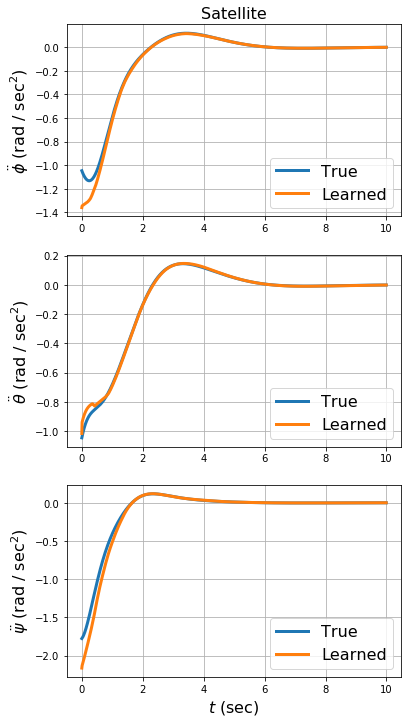

In [37]:
x_dots = array([sat.eval_dot(x, u, t) for x, u, t in zip(xs, us, ts)])
q_ddots = x_dots[:, -3:]

_, axs = subplots(3, figsize=(width, 3 * height))
axs[0].set_title('Satellite', fontsize=16)
axs[-1].set_xlabel('$t$ (sec)', fontsize=16)
ylabels = ['$\\ddot{\\phi}$ (rad / sec$^2$)', '$\\ddot{\\theta}$ (rad / sec$^2$)', '$\\ddot{\\psi}$ (rad / sec$^2$)']

for ax, data, ylabel in zip(axs, q_ddots.T, ylabels):
    ax.plot(ts[:-1], data, linewidth=3, label='True')
    ax.grid()
    ax.set_ylabel(ylabel, fontsize=16)
    
x_dots = array([sat_learned.eval_dot(x, u, t) for x, u, t in zip(xs, us, ts)])
q_ddots = x_dots[:, -3:]

for ax, data in zip(axs, q_ddots.T):
    ax.plot(ts[:-1], data, linewidth=3, label='Learned')
    ax.legend(fontsize=16)
    
show()

## Underdetermined Learning

### Inverted Pendulum

In [38]:
lqr_ip_learned = LQRController.build(ip_learned, Q_ip, R_ip)
fb_lin_ip_learned = FBLinController(ip_learned, lqr_ip_learned)

In [39]:
xs, _ = ip.simulate(x_0_ip, fb_lin_ip_learned, ts)
qs = xs[:, :1]

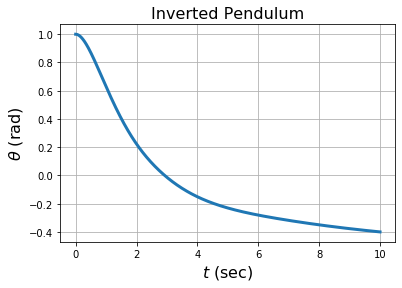

In [40]:
_, ax = subplots(figsize=(width, height))

ax.plot(ts, (qs.T)[0], linewidth=3)
ax.grid()
ax.set_title('Inverted Pendulum', fontsize=16)
ax.set_xlabel('$t$ (sec)', fontsize=16)
ax.set_ylabel('$\\theta$ (rad)', fontsize=16)

show()

### Double Inverted Pendulum

In [41]:
lqr_dip_learned = LQRController.build(dip_learned, Q_dip, R_dip)
fb_lin_dip_learned = FBLinController(dip_learned, lqr_dip_learned)

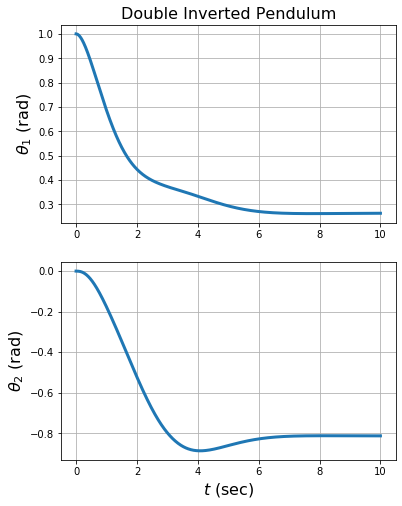

In [42]:
xs, _ = dip.simulate(x_0_dip, fb_lin_dip_learned, ts)
qs = xs[:, :2]

_, axs = subplots(2, figsize=(width, 2 * height))
axs[0].set_title('Double Inverted Pendulum', fontsize=16)
axs[-1].set_xlabel('$t$ (sec)', fontsize=16)
ylabels = ['$\\theta_1$ (rad)', '$\\theta_2$ (rad)']

for ax, data, ylabel in zip(axs, qs.T, ylabels):
    ax.plot(ts, data, linewidth=3)
    ax.grid()
    ax.set_ylabel(ylabel, fontsize=16)

show()

### Satellite

In [43]:
lqr_sat_learned = LQRController.build(sat_learned, Q_sat, R_sat)
fb_lin_sat_learned = FBLinController(sat_learned, lqr_sat_learned)

In [44]:
xs, _ = sat.simulate(x_0_sat, fb_lin_sat_learned, ts)
qs = xs[:, :3]

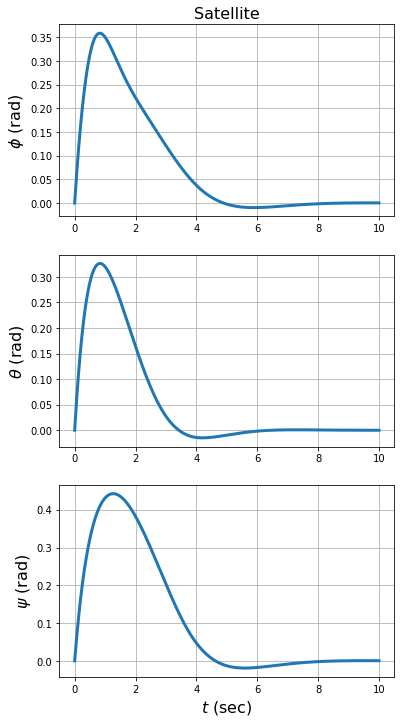

In [45]:
_, axs = subplots(3, figsize=(width, 3 * height))
axs[0].set_title('Satellite', fontsize=16)
axs[-1].set_xlabel('$t$ (sec)', fontsize=16)
ylabels = ['$\\phi$ (rad)', '$\\theta$ (rad)', '$\\psi$ (rad)']

for ax, data, ylabel in zip(axs, qs.T, ylabels):
    ax.plot(ts, data, linewidth=3)
    ax.grid()
    ax.set_ylabel(ylabel, fontsize=16)
    
show()

## Episodic Learning

In [46]:
from IPython.display import display

### Inverted Pendulum

In [47]:
xs, us = data_ip_oracle
drift_inputs = xs[:-1]
act_inputs = xs[:-1, :1]
residuals = array([ip.eval_dot(x, u, t) - ip_est.eval_dot(x, u, t) for x, u, t in zip(xs, us, ts)])[:, -1:]
validation_data = [drift_inputs, act_inputs, us], residuals

In [48]:
data_agg = LearnedRoboticDynamics.init_data(d_drift_in_ip, d_act_in_ip, 1, d_out_ip)
trusts = linspace(0, 1, 5 + 1)
controller = fb_lin_ip_est

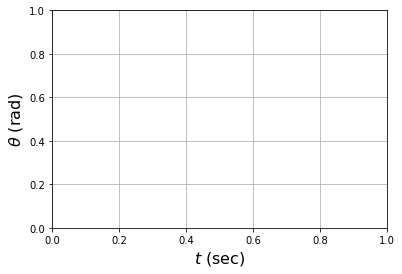

In [49]:
lines = []
base_alpha = 0.7

fig, ax = subplots(figsize=(width, height))
ax.grid()
ax.set_xlabel('$t$ (sec)', fontsize=16)
ax.set_ylabel('$\\theta$ (rad)', fontsize=16)

show()

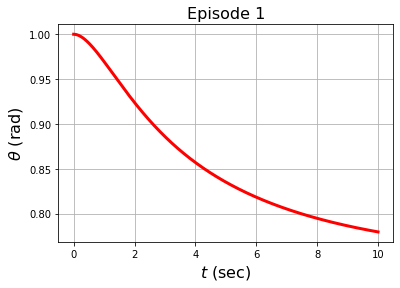

Train on 998 samples, validate on 1000 samples
Epoch 1/10
998/998 [==============================] - 3s 3ms/step - loss: 0.1437 - val_loss: 0.2646
Epoch 2/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0039 - val_loss: 0.2808
Epoch 3/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0027 - val_loss: 0.2851
Epoch 4/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0025 - val_loss: 0.2843
Epoch 5/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0022 - val_loss: 0.2847
Epoch 6/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0025 - val_loss: 0.2868
Epoch 7/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0021 - val_loss: 0.2903
Epoch 8/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0021 - val_loss: 0.2902
Epoch 9/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0022 - val_loss: 0.2914
Epoch 10/10
998/998 [==============================] 

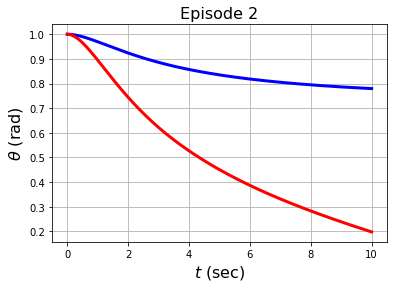

Train on 1996 samples, validate on 1000 samples
Epoch 1/10
1996/1996 [==============================] - 5s 2ms/step - loss: 0.0568 - val_loss: 0.1542
Epoch 2/10
1996/1996 [==============================] - 4s 2ms/step - loss: 0.0084 - val_loss: 0.1057
Epoch 3/10
1996/1996 [==============================] - 5s 3ms/step - loss: 0.0050 - val_loss: 0.0820
Epoch 4/10
1996/1996 [==============================] - 6s 3ms/step - loss: 0.0042 - val_loss: 0.0727
Epoch 5/10
1996/1996 [==============================] - 4s 2ms/step - loss: 0.0041 - val_loss: 0.0676
Epoch 6/10
1996/1996 [==============================] - 4s 2ms/step - loss: 0.0043 - val_loss: 0.0613
Epoch 7/10
1996/1996 [==============================] - 5s 2ms/step - loss: 0.0037 - val_loss: 0.0611
Epoch 8/10
1996/1996 [==============================] - 6s 3ms/step - loss: 0.0040 - val_loss: 0.0608
Epoch 9/10
1996/1996 [==============================] - 5s 3ms/step - loss: 0.0035 - val_loss: 0.0588
Epoch 10/10
1996/1996 [===========

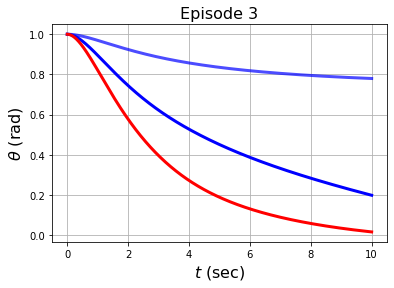

Train on 2994 samples, validate on 1000 samples
Epoch 1/10
2994/2994 [==============================] - 9s 3ms/step - loss: 0.0379 - val_loss: 0.0241
Epoch 2/10
2994/2994 [==============================] - 8s 3ms/step - loss: 0.0059 - val_loss: 0.0265
Epoch 3/10
2994/2994 [==============================] - 8s 3ms/step - loss: 0.0058 - val_loss: 0.0256
Epoch 4/10
2994/2994 [==============================] - 6s 2ms/step - loss: 0.0050 - val_loss: 0.0276
Epoch 5/10
2994/2994 [==============================] - 6s 2ms/step - loss: 0.0054 - val_loss: 0.0296
Epoch 6/10
2994/2994 [==============================] - 6s 2ms/step - loss: 0.0052 - val_loss: 0.0260
Epoch 7/10
2994/2994 [==============================] - 6s 2ms/step - loss: 0.0048 - val_loss: 0.0243
Epoch 8/10
2994/2994 [==============================] - 6s 2ms/step - loss: 0.0056 - val_loss: 0.0294
Epoch 9/10
2994/2994 [==============================] - 6s 2ms/step - loss: 0.0050 - val_loss: 0.0278
Epoch 10/10
2994/2994 [===========

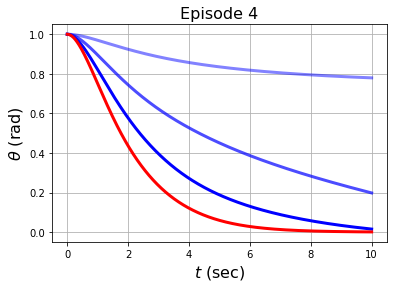

Train on 3992 samples, validate on 1000 samples
Epoch 1/10
3992/3992 [==============================] - 8s 2ms/step - loss: 0.0281 - val_loss: 0.0192
Epoch 2/10
3992/3992 [==============================] - 8s 2ms/step - loss: 0.0064 - val_loss: 0.0158
Epoch 3/10
3992/3992 [==============================] - 7s 2ms/step - loss: 0.0059 - val_loss: 0.0166
Epoch 4/10
3992/3992 [==============================] - 8s 2ms/step - loss: 0.0057 - val_loss: 0.0168
Epoch 5/10
3992/3992 [==============================] - 7s 2ms/step - loss: 0.0055 - val_loss: 0.0174
Epoch 6/10
3992/3992 [==============================] - 8s 2ms/step - loss: 0.0052 - val_loss: 0.0153
Epoch 7/10
3992/3992 [==============================] - 8s 2ms/step - loss: 0.0052 - val_loss: 0.0141
Epoch 8/10
3992/3992 [==============================] - 7s 2ms/step - loss: 0.0046 - val_loss: 0.0124
Epoch 9/10
3992/3992 [==============================] - 7s 2ms/step - loss: 0.0051 - val_loss: 0.0166
Epoch 10/10
3992/3992 [===========

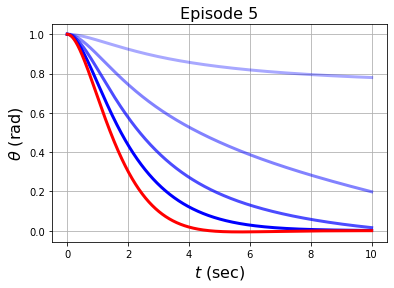

Train on 4990 samples, validate on 1000 samples
Epoch 1/10
4990/4990 [==============================] - 14s 3ms/step - loss: 0.0136 - val_loss: 0.0132
Epoch 2/10
4990/4990 [==============================] - 15s 3ms/step - loss: 0.0068 - val_loss: 0.0139
Epoch 3/10
4990/4990 [==============================] - 12s 2ms/step - loss: 0.0061 - val_loss: 0.0084
Epoch 4/10
4990/4990 [==============================] - 14s 3ms/step - loss: 0.0058 - val_loss: 0.0119
Epoch 5/10
4990/4990 [==============================] - 12s 2ms/step - loss: 0.0056 - val_loss: 0.0156
Epoch 6/10
4990/4990 [==============================] - 13s 3ms/step - loss: 0.0055 - val_loss: 0.0094
Epoch 7/10
4990/4990 [==============================] - 13s 3ms/step - loss: 0.0056 - val_loss: 0.0144
Epoch 8/10
4990/4990 [==============================] - 12s 2ms/step - loss: 0.0056 - val_loss: 0.0145
Epoch 9/10
4990/4990 [==============================] - 12s 2ms/step - loss: 0.0055 - val_loss: 0.0170
Epoch 10/10
4990/4990 [==

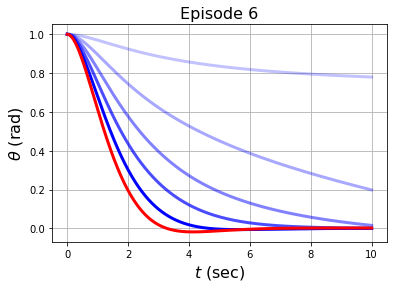

In [50]:
for ep, trust in enumerate(trusts[:-1]):
    # Simulate system
    xs, us = ip.simulate(x_0_ip, controller, ts)
    qs = xs[:, :1]
    
    # Plot simulation data
    line, = ax.plot(ts, (qs.T)[0], 'r', linewidth=3)
    lines.append(line)
    
    for power, line in enumerate(lines[-2::-1]):
        line.set_color('b')
        line.set_alpha(base_alpha ** power)
    
    ax.set_title('Episode ' + str(ep + 1), fontsize=16)
    
    display(fig)
    
    # Reinitialize model, increase model trust
    res_model = KerasResidualAffineModel.build(d_drift_in_ip, d_act_in_ip, d_hidden_ip, 1, d_out_ip, 'adam')
    ip_learned = LearnedRoboticDynamics(ip_est, res_model, trusts[ep + 1])
    
    # Process and aggregate data
    new_data = ip_learned.process_episode(xs, us, ts)
    data_agg = LearnedRoboticDynamics.aggregate_data(data_agg, new_data)
    
    # Fit estimator
    ip_learned.fit(data_agg, num_epochs=10, validation_data=validation_data)
    
    # Update controller
    lqr = LQRController.build(ip_learned, Q_ip, R_ip)
    controller = FBLinController(ip_learned, lqr)
    
xs, us = ip.simulate(x_0_ip, controller, ts)
qs = xs[:, :1]

line, = ax.plot(ts, (qs.T)[0], 'r', linewidth=3)
lines.append(line)

for power, line in enumerate(lines[-2::-1]):
    line.set_color('b')
    line.set_alpha(base_alpha ** power)

ax.set_title('Episode ' + str(len(trusts)), fontsize=16)

display(fig)

### Double Inverted Pendulum

In [51]:
xs, us = data_dip_oracle
drift_inputs = xs[:-1]
act_inputs = xs[:-1, :2]
residuals = array([dip.eval_dot(x, u, t) - dip_est.eval_dot(x, u, t) for x, u, t in zip(xs, us, ts)])[:, -2:]
validation_data = [drift_inputs, act_inputs, us], residuals

In [52]:
from numpy import concatenate

data_agg = LearnedRoboticDynamics.init_data(d_drift_in_dip, d_act_in_dip, 2, d_out_dip)
trusts = linspace(0, 1, 5 + 1)
controller = fb_lin_dip_est

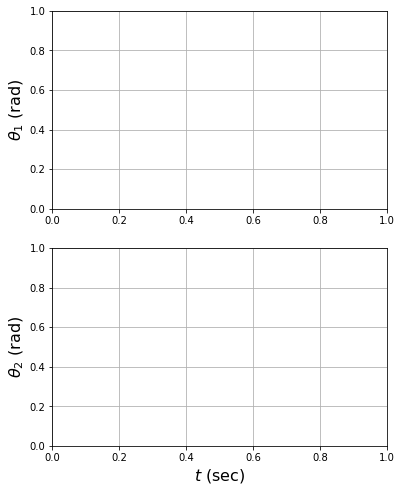

In [53]:
plots = [[] for _ in range(2)]
base_alpha = 0.7

fig, axs = subplots(2, figsize=(width, 2 * height))
axs[-1].set_xlabel('$t$ (sec)', fontsize=16)
ylabels = ['$\\theta_1$ (rad)', '$\\theta_2$ (rad)']

for ax, ylabel in zip(axs, ylabels):
    ax.grid()
    ax.set_ylabel(ylabel, fontsize=16)

show()

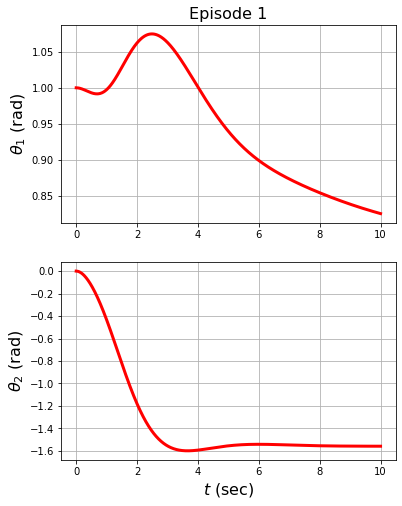

Train on 998 samples, validate on 1000 samples
Epoch 1/10
998/998 [==============================] - 4s 4ms/step - loss: 0.1328 - val_loss: 0.3035
Epoch 2/10
998/998 [==============================] - 3s 3ms/step - loss: 0.0315 - val_loss: 0.3525
Epoch 3/10
998/998 [==============================] - 4s 4ms/step - loss: 0.0303 - val_loss: 0.3585
Epoch 4/10
998/998 [==============================] - 3s 3ms/step - loss: 0.0282 - val_loss: 0.3646
Epoch 5/10
998/998 [==============================] - 3s 3ms/step - loss: 0.0253 - val_loss: 0.3696
Epoch 6/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0240 - val_loss: 0.3756
Epoch 7/10
998/998 [==============================] - 2s 3ms/step - loss: 0.0246 - val_loss: 0.3796
Epoch 8/10
998/998 [==============================] - 2s 2ms/step - loss: 0.0223 - val_loss: 0.3995
Epoch 9/10
998/998 [==============================] - 4s 4ms/step - loss: 0.0235 - val_loss: 0.3994
Epoch 10/10
998/998 [==============================] 

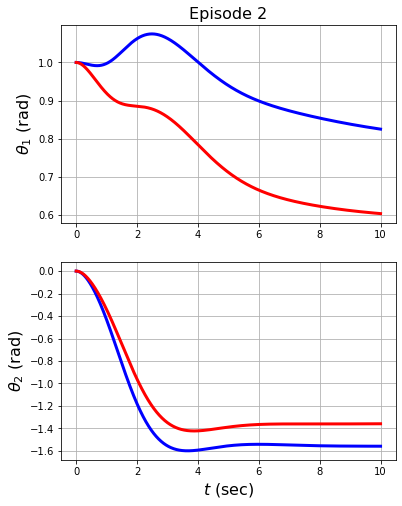

Train on 1996 samples, validate on 1000 samples
Epoch 1/10
1996/1996 [==============================] - 5s 3ms/step - loss: 0.1762 - val_loss: 0.5533
Epoch 2/10
1996/1996 [==============================] - 4s 2ms/step - loss: 0.0422 - val_loss: 0.7656
Epoch 3/10
1996/1996 [==============================] - 4s 2ms/step - loss: 0.0294 - val_loss: 0.8080
Epoch 4/10
1996/1996 [==============================] - 4s 2ms/step - loss: 0.0257 - val_loss: 0.8059
Epoch 5/10
1996/1996 [==============================] - 4s 2ms/step - loss: 0.0221 - val_loss: 0.8258
Epoch 6/10
1996/1996 [==============================] - 4s 2ms/step - loss: 0.0210 - val_loss: 0.8395
Epoch 7/10
1996/1996 [==============================] - 4s 2ms/step - loss: 0.0195 - val_loss: 0.8335
Epoch 8/10
1996/1996 [==============================] - 4s 2ms/step - loss: 0.0187 - val_loss: 0.8484
Epoch 9/10
1996/1996 [==============================] - 4s 2ms/step - loss: 0.0171 - val_loss: 0.8560
Epoch 10/10
1996/1996 [===========

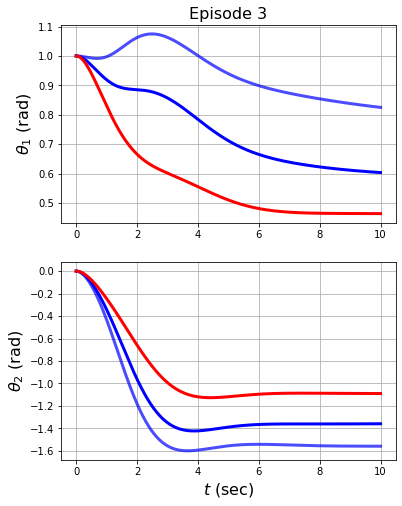

Train on 2994 samples, validate on 1000 samples
Epoch 1/10
2994/2994 [==============================] - 7s 2ms/step - loss: 0.1475 - val_loss: 1.0111
Epoch 2/10
2994/2994 [==============================] - 7s 2ms/step - loss: 0.0357 - val_loss: 1.0694
Epoch 3/10
2994/2994 [==============================] - 6s 2ms/step - loss: 0.0248 - val_loss: 1.1113
Epoch 4/10
2994/2994 [==============================] - 7s 2ms/step - loss: 0.0207 - val_loss: 1.1601
Epoch 5/10
2994/2994 [==============================] - 6s 2ms/step - loss: 0.0182 - val_loss: 1.1774
Epoch 6/10
2994/2994 [==============================] - 6s 2ms/step - loss: 0.0170 - val_loss: 1.2059
Epoch 7/10
2994/2994 [==============================] - 6s 2ms/step - loss: 0.0159 - val_loss: 1.2101
Epoch 8/10
2994/2994 [==============================] - 6s 2ms/step - loss: 0.0144 - val_loss: 1.2156
Epoch 9/10
2994/2994 [==============================] - 6s 2ms/step - loss: 0.0140 - val_loss: 1.2032
Epoch 10/10
2994/2994 [===========

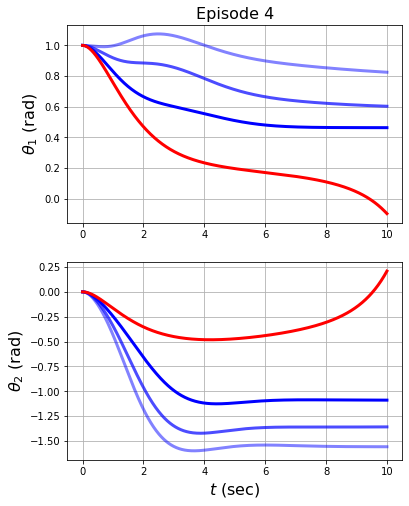

Train on 3992 samples, validate on 1000 samples
Epoch 1/10
3992/3992 [==============================] - 9s 2ms/step - loss: 0.1449 - val_loss: 0.6210
Epoch 2/10
3992/3992 [==============================] - 8s 2ms/step - loss: 0.0242 - val_loss: 0.5844
Epoch 3/10
3992/3992 [==============================] - 8s 2ms/step - loss: 0.0199 - val_loss: 0.5837
Epoch 4/10
3992/3992 [==============================] - 8s 2ms/step - loss: 0.0173 - val_loss: 0.5716
Epoch 5/10
3992/3992 [==============================] - 8s 2ms/step - loss: 0.0158 - val_loss: 0.5617
Epoch 6/10
3992/3992 [==============================] - 8s 2ms/step - loss: 0.0146 - val_loss: 0.5551
Epoch 7/10
3992/3992 [==============================] - 8s 2ms/step - loss: 0.0138 - val_loss: 0.5530
Epoch 8/10
3992/3992 [==============================] - 8s 2ms/step - loss: 0.0135 - val_loss: 0.5469
Epoch 9/10
3992/3992 [==============================] - 8s 2ms/step - loss: 0.0135 - val_loss: 0.5499
Epoch 10/10
3992/3992 [===========

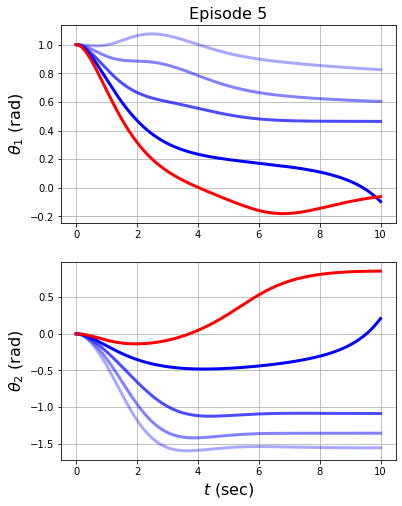

Train on 4990 samples, validate on 1000 samples
Epoch 1/10
4990/4990 [==============================] - 12s 2ms/step - loss: 0.1229 - val_loss: 0.3225
Epoch 2/10
4990/4990 [==============================] - 11s 2ms/step - loss: 0.0325 - val_loss: 0.2662
Epoch 3/10
4990/4990 [==============================] - 11s 2ms/step - loss: 0.0267 - val_loss: 0.2116
Epoch 4/10
4990/4990 [==============================] - 11s 2ms/step - loss: 0.0245 - val_loss: 0.1756
Epoch 5/10
4990/4990 [==============================] - 11s 2ms/step - loss: 0.0214 - val_loss: 0.1495
Epoch 6/10
4990/4990 [==============================] - 11s 2ms/step - loss: 0.0199 - val_loss: 0.1234
Epoch 7/10
4990/4990 [==============================] - 13s 3ms/step - loss: 0.0190 - val_loss: 0.1042
Epoch 8/10
4990/4990 [==============================] - 13s 3ms/step - loss: 0.0178 - val_loss: 0.0849
Epoch 9/10
4990/4990 [==============================] - 12s 2ms/step - loss: 0.0166 - val_loss: 0.0560
Epoch 10/10
4990/4990 [==

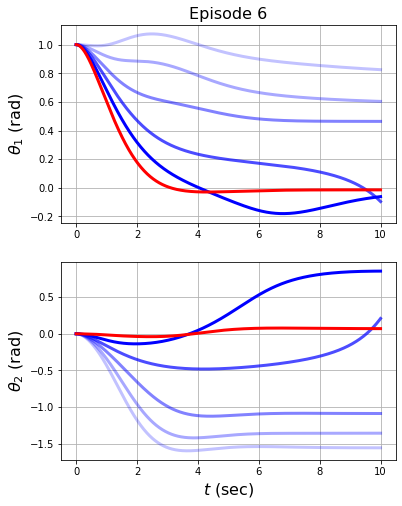

In [54]:
for ep, trust in enumerate(trusts[:-1]):
    # Simulate system
    xs, us = dip.simulate(x_0_dip, controller, ts)
    qs = xs[:, :2]
    
    # Plot simulation data
    for ax, data, lines in zip(axs, qs.T, plots):
        line, = ax.plot(ts, data, 'r', linewidth=3)
        lines.append(line)
        
        for power, line in enumerate(lines[-2::-1]):
            line.set_color('b')
            line.set_alpha(base_alpha ** power)
    
    axs[0].set_title('Episode ' + str(ep + 1), fontsize=16)
    
    display(fig)
    
    # Reinitialize model, increase model trust
    res_model = KerasResidualAffineModel.build(d_drift_in_dip, d_act_in_dip, d_hidden_dip // 2, 2, d_out_dip, 'adam')
    dip_learned = LearnedRoboticDynamics(dip_est, res_model, trusts[ep + 1])
    
    # Process and aggregate data
    new_data = dip_learned.process_episode(xs, us, ts)
    data_agg = LearnedRoboticDynamics.aggregate_data(data_agg, new_data)
    
    # Fit estimator
    dip_learned.fit(data_agg, num_epochs=10, validation_data=validation_data)
    
    # Update controller
    lqr = LQRController.build(dip_learned, Q_dip, R_dip)
    controller = FBLinController(dip_learned, lqr)
    
xs, us = dip.simulate(x_0_dip, controller, ts)
qs = xs[:, :2]

for ax, data, lines in zip(axs, qs.T, plots):
    line, = ax.plot(ts, data, 'r', linewidth=3)
    lines.append(line)

    for power, line in enumerate(lines[-2::-1]):
        line.set_color('b')
        line.set_alpha(base_alpha ** power)

axs[0].set_title('Episode ' + str(len(trusts)), fontsize=16)

display(fig)

The final controller almost stabilizes the system upright. Let's use the data gathered from the last simulation for one more episode of training.

Train on 5988 samples, validate on 1000 samples
Epoch 1/10
5988/5988 [==============================] - 16s 3ms/step - loss: 0.1340 - val_loss: 0.0481
Epoch 2/10
5988/5988 [==============================] - 14s 2ms/step - loss: 0.0306 - val_loss: 0.0288
Epoch 3/10
5988/5988 [==============================] - 16s 3ms/step - loss: 0.0244 - val_loss: 0.0238
Epoch 4/10
5988/5988 [==============================] - 14s 2ms/step - loss: 0.0217 - val_loss: 0.0149
Epoch 5/10
5988/5988 [==============================] - 14s 2ms/step - loss: 0.0197 - val_loss: 0.0060
Epoch 6/10
5988/5988 [==============================] - 13s 2ms/step - loss: 0.0190 - val_loss: 0.0165
Epoch 7/10
5988/5988 [==============================] - 15s 2ms/step - loss: 0.0175 - val_loss: 0.0212
Epoch 8/10
5988/5988 [==============================] - 17s 3ms/step - loss: 0.0170 - val_loss: 0.0109
Epoch 9/10
5988/5988 [==============================] - 14s 2ms/step - loss: 0.0162 - val_loss: 0.0131
Epoch 10/10
5988/5988 [==

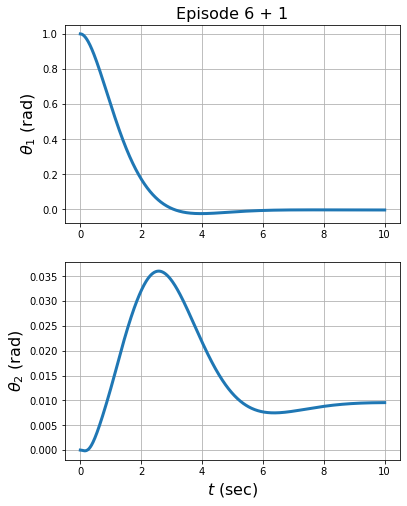

In [55]:
res_model = KerasResidualAffineModel.build(d_drift_in_dip, d_act_in_dip, d_hidden_dip // 2, 2, d_out_dip, 'adam')
dip_learned = LearnedRoboticDynamics(dip_est, res_model, trusts[ep + 1])

new_data = dip_learned.process_episode(xs, us, ts)
data_agg = LearnedRoboticDynamics.aggregate_data(data_agg, new_data)

dip_learned.fit(data_agg, num_epochs=10, validation_data=validation_data)

lqr = LQRController.build(dip_learned, Q_dip, R_dip)
controller = FBLinController(dip_learned, lqr)

xs, us = dip.simulate(x_0_dip, controller, ts)
qs = xs[:, :2]

_, axs = subplots(2, figsize=(width, 2 * height))
axs[0].set_title('Episode ' + str(len(trusts)) + ' + 1', fontsize=16)
axs[-1].set_xlabel('$t$ (sec)', fontsize=16)
ylabels = ['$\\theta_1$ (rad)', '$\\theta_2$ (rad)']

for ax, data, ylabel in zip(axs, qs.T, ylabels):
    ax.plot(ts, data, linewidth=3)
    ax.grid()
    ax.set_ylabel(ylabel, fontsize=16)

show()